# Linear regression with an evolutionary algorithm

In this notebook, we will show how to use Auxein and a simple evolutionary algorithm to perfom a [simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression).

In [1]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import os
import logging

logging.getLogger().setLevel(logging.CRITICAL)

As a first step, we will randomly generate $100$ data points in the form of $(x_{i},y_{i})$ representing our observations of a linear function $y = f(x)$ affected by some uniform noise.

In [2]:
size = 100

x = np.arange(size)

delta = np.random.uniform(-15,15, size=(size,))

y = .4*x + 3 + delta

And then we visualise our observations drawn from $(x_{i},y_{i})$:

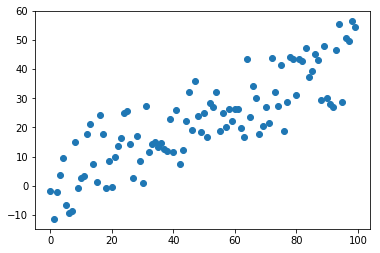

In [3]:
plt.scatter(x, y);

From now on, we will only assume that we have our observations $(x_{i},y_{i})$ and that we do not know the function $y = f(x)$ that generated them.

Our goal is to find a function $\hat{f} = ax + b$ such as $\hat{f} \sim f$, which means finding $a$ and $b$ of the linear equation.

The first thing to do is to use the $(x,y)$ observations and wrap them with a [Fitness function](https://github.com/auxein/auxein/blob/master/auxein/fitness/core.py#L15) $\phi$ that Auxein can explore.

Auxein comes with some pre-defined fitness functions. In this case, for our linear regression problem, we will use the [MultipleLinearRegression](https://github.com/auxein/auxein/blob/master/auxein/fitness/core.py#L38).

In [4]:
from auxein.fitness import MultipleLinearRegression
fitness_function = MultipleLinearRegression(x.reshape(size, 1), y)

Then, the second step is to create an initial `population` of individuals. Each `individual` maps to candidate solution, which in this case would be a vector $(a, b)$.
Auxein provides some utility functions to create initial populations, like the `build_fixed_dimension_population` used below.

In [5]:
from auxein.population.dna_builders import UniformRandomDnaBuilder
from auxein.population import build_fixed_dimension_population
population = build_fixed_dimension_population(2, 100, fitness_function, UniformRandomDnaBuilder((-10, -5)))

Once we have a `fitness_function` and an initial `population`, we need to set up a [Playground](https://github.com/auxein/auxein/blob/master/auxein/playgrounds/static.py#L27).
A playground is basically the object that represents our experiment.

In [6]:
from auxein.playgrounds import Static
from auxein.mutations import SelfAdaptiveSingleStep
from auxein.recombinations import SimpleArithmetic
from auxein.parents.distributions import SigmaScaling
from auxein.parents.selections import StochasticUniversalSampling
from auxein.replacements import ReplaceWorst

In order to instantiate a `playground` the following must be specified:
* `mutation` strategy, which describes how `individual` dna will mutate. In this case we will use the [SelfAdaptiveSingleStep](https://github.com/auxein/auxein/blob/master/auxein/mutations/core.py#L62).
* parents `distribution`, which gives a probability distribution for parents `selection`. We here use [SigmaScaling](https://github.com/auxein/auxein/blob/master/auxein/parents/distributions/core.py#L43) for distribution and [StochasticUniversalSampling](https://github.com/auxein/auxein/blob/master/auxein/parents/selections/core.py#L27) for selection.
* `recombination` defines how fresh dna are created when `individual`s breed. Here we use the basic [SimpleArithmetic](https://github.com/auxein/auxein/blob/master/auxein/recombinations/core.py#L23).
* for `replacement` we will use the basic [ReplaceWorst](https://github.com/auxein/auxein/blob/master/auxein/replacements/core.py#L34) which basically only replaces the 2-worst performing individuals.

In [7]:
offspring_size = 2
playground = Static(
    population = population,
    fitness = fitness_function,
    mutation = SelfAdaptiveSingleStep(0.05),
    distribution = SigmaScaling(),
    selection = StochasticUniversalSampling(offspring_size = offspring_size),
    recombination = SimpleArithmetic(alpha = 0.5),
    replacement = ReplaceWorst(offspring_size = offspring_size)
)

Invoking `playground.train(max_generations = )` will trigger the evolution process up to a maximum of $250$ generations.

In [8]:
stats = playground.train(250)

INFO:root:Starting evolution cycle with a maximum of 250 generations
INFO:root:Training ended with average_fitness: -181198.40663362804


Once the training phase has ended, the `playground` returns a dictionary with some basic statistics on the population.

In [9]:
population.get_stats()

{'generation_count': 250,
 'size': 100,
 'mean_age': 2.813690185546875,
 'std_age': 1.8698373636893493,
 'max_age': 9.806667804718018,
 'min_age': 0.03953838348388672,
 'mean_fitness': -181198.40663362804,
 'min_fitness': -963060.5490445388,
 'max_fitness': -7369.584775505627,
 'std_fitness': 172685.33025112792}

To get the most performant `individual` we can invoke `playground.get_most_performant()` and grab the dna of the individual.

In [10]:
[a, b] = playground.get_most_performant().genotype.dna

In our case, the dna is a vector of dimension $2$ where the first scalar is our $a$ coefficient and the second is $b$.

In [11]:
[a, b]

[0.5248231628474164, -4.794083961880094]

Once we have $a$ and $b$, it might be useful to plot $\hat{f} = ax + b$ against our observations $(x_{i},y_{i})$, to visually inspect the quality of our regression:

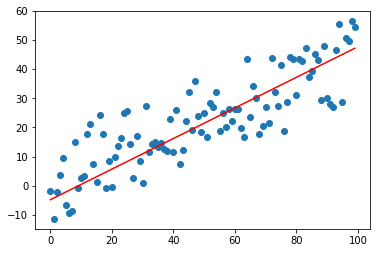

In [12]:
y_pred = a*x + b
plt.scatter(x, y);
plt.plot(x, y_pred, color='red');

It would be also useful to see how the mean fitness value changed over the generations. Intuitively, an increasing mean fitness might indicate that the evolution process is selecting better solutions for our problem.

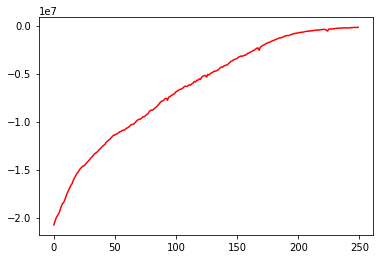

In [13]:
mean_fitness_values = []
for g in stats['generations'].values():
    mean_fitness_values.append(g['mean_fitness'])

plt.plot(stats['generations'].keys(), mean_fitness_values, color='red');

It's probably worth noting as after a certain number of generations, the mean fitness doesn't improve anymore, making totally pointless to keep the evolution process going on.